In [1]:
from importlib import reload

In [2]:
import env
import sys
import os
import source
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
from tqdm import tqdm

In [13]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

## Import Data

In [14]:
reload(source)
features = source.features(60)
print('Shape', features.shape)
print('Columns: ['+', '.join(features.columns)+']')

Shape (87460, 24)
Columns: [gid, team, gameNumber, home, spread, win, win_rate, expected_win, log5, lob_rate, win_vs_rate, scored_vs_rate, e, ba, slg, obp, ops, rbi, bb, era, k, pbb, ptb, phits]


In [6]:
dependent_col = 'win'

In [7]:
gameNumberThreshold = 20

In [15]:
def selectSeasons(dataset, start=2007, end=2012):
    year = np.array([int(g[:4]) for g in dataset.gid])
    return dataset.loc[(year >= start) & (year <= end)]

In [20]:
stat_groups = {
    'batting':['ba', 'slg', 'obp', 'rbi', 'bb'],
    'pitching':['era','k','pbb','ptb','phits'],
    'team':['home', 'win_rate', 'expected_win','log5', 'lob_rate','win_vs_rate','scored_vs_rate', 'e']
}

In [17]:
dataset = selectSeasons(features, 2007, 2012)
dataset = dataset.loc[dataset.gameNumber > gameNumberThreshold]
dataset = dataset.dropna().drop(columns=['gid', 'team', 'gameNumber'])

In [11]:
dataset.head()

,home,spread,win,win_rate,expected_win,log5,lob_rate,win_vs_rate,scored_vs_rate,e,...,slg,obp,ops,rbi,bb,era,k,pbb,ptb,phits
29703,1,-5,0,0.50000,2.051274,0.421053,7.450000,0.500000,0.458333,0.700000,...,0.436993,0.323944,0.760937,0.129698,0.074000,5.004878,0.200000,0.068605,0.375581,0.225581
29718,0,-1,0,0.40000,2.679032,0.250000,8.000000,0.000000,0.142857,0.350000,...,0.433900,0.354745,0.788645,0.141525,0.099229,4.205841,0.102713,0.050388,0.380814,0.261628
29730,0,-1,0,0.60000,1.709141,0.622642,7.950000,0.666667,0.589744,0.500000,...,0.432712,0.334780,0.767492,0.138026,0.084152,3.874085,0.247368,0.061053,0.361053,0.218947
29731,1,1,1,0.47619,2.173611,0.377358,7.380952,0.333333,0.410256,0.714286,...,0.421282,0.320680,0.741962,0.129434,0.073348,3.194656,0.192164,0.054104,0.331157,0.229478
29734,0,4,1,0.55000,1.815251,0.470588,6.600000,0.333333,0.468750,0.650000,...,0.431440,0.315978,0.747418,0.140548,0.068334,10.536585,0.140625,0.093750,0.578125,0.312500


In [22]:
def fit_linear_reg(x, y):
    """
    Fit linear regression model and return RSS and R squared values

    Returns
    --------
    tuple
        returns (RSS, R_squared) values of the linear regression model
    """
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(x, y)
    RSS = mean_squared_error(y, model_k.predict(x)) * len(y)
    R_squared = model_k.score(x, y)
    return RSS, R_squared

def best_subset_selection(data, x, y=dependent_col):
    #Initialization variables
    Y = data[y]
    X = data[x]
    RSS_list, R_squared_list, feature_list = [],[], []
    numb_features = []
    #Looping over k = 1 to k = 11 features in X
    for k in tqdm(range(1,len(x) + 1)):
        #Looping over all possible combinations: from 11 choose k
        for combo in itertools.combinations(X.columns,k):
            #Store temp result
            tmp_result = fit_linear_reg(X[list(combo)],Y)
            #Append lists
            RSS_list.append(tmp_result[0])
            R_squared_list.append(tmp_result[1])
            feature_list.append(combo)
            numb_features.append(len(combo))

    #Store in DataFrame
    df = pd.DataFrame({'n': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})
    # Adding columns to the dataframe with RSS and R squared values of the best subset
    df['min_RSS'] = (df.groupby('n')['RSS'].transform(min) == df['RSS'])
    df['max_R_squared'] = (df.groupby('n')['R_squared'].transform(max) == df['R_squared'])
    return df

def plot_best_subset_selection(df):
    # RSS max
    rss_min = df.groupby('n')['RSS'].transform(min)
    rsq_max = df.groupby('n')['R_squared'].transform(max)
    # create figure
    fig = plt.figure(figsize = (16,6))
    
    #fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")
    #gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
    
    # Create RSS Table
    
    ax1 = fig.add_subplot(1, 2, 1)
    #axt1 = fig.add_subplot(gs[0])
    rss = df[df['RSS'] == rss_min]
    #ax1.axis('off')
    t1 = ax1.table(
        cellText=np.column_stack([
            [','.join(x) for x in rss['features'].values],
        ]),
        rowLabels = rss['n'].values.astype(str),
        bbox=[0, -0.6, 1, 0.5],
        cellLoc='left',
        loc='center'
    )
    t1.auto_set_font_size(False)
    t1.set_fontsize(12)
    for k, cell in t1._cells.items():
        cell.set_text_props(fontfamily='monospace')
        cell.set_edgecolor('#bbbbbb')
        if k[1]==-1:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor('#40466e')
        else:
            cell.PAD = 0.01
    
    # Create RSS Plot
    #ax1 = fig.add_subplot(gs[2])
    ax1.scatter(df.n,df.RSS, alpha = .2, color = 'darkblue' )
    ax1.set_xlabel('# Features')
    ax1.set_ylabel('RSS')
    ax1.set_title('RSS - Best subset selection')
    ax1.plot(df.n,rss_min,color = 'r', label = 'Best subset')
    ax1.legend()
    # Create R_Squared table
    #axt2 = fig.add_subplot(gs[1])
    ax2 = fig.add_subplot(1, 2, 2)
    rsq = df[df['R_squared'] == rsq_max]
    #ax2.axis('off')
    t2 = ax2.table(
        
        cellText=np.column_stack([
            [','.join(x) for x in rsq['features'].values],
        ]),
        rowLabels = rsq['n'].values.astype(str),
        bbox=[0, -0.6, 1, 0.5],
        cellLoc='left',
        loc='center'
    )
    t2.auto_set_font_size(False)
    t2.set_fontsize(12)
    for k, cell in t2._cells.items():
        cell.set_text_props(fontfamily='monospace')
        cell.set_edgecolor('#bbbbbb')
        if k[1]==-1:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor('#40466e')
        else:
            cell.PAD = 0.01
        
    
    # Create R_Squared plot
    #ax2 = fig.add_subplot(gs[3])
    ax2.scatter(df.n,df.R_squared, alpha = .2, color = 'darkblue' )
    ax2.plot(df.n,rsq_max,color = 'r', label = 'Best subset')
    ax2.set_xlabel('# Features')
    ax2.set_ylabel('R squared')
    ax2.set_title('R_squared - Best subset selection')
    ax2.legend()
    # Show figure
    plt.show()

100%|██████████| 8/8 [00:02<00:00,  3.69it/s]


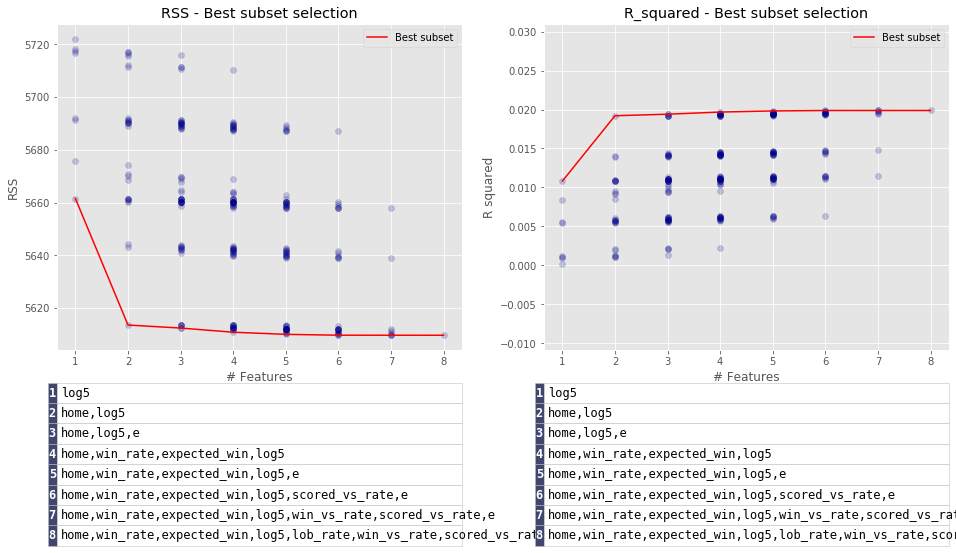

In [23]:
team_subset = best_subset_selection(dataset, stat_groups['team'])
plot_best_subset_selection(team_subset)

100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


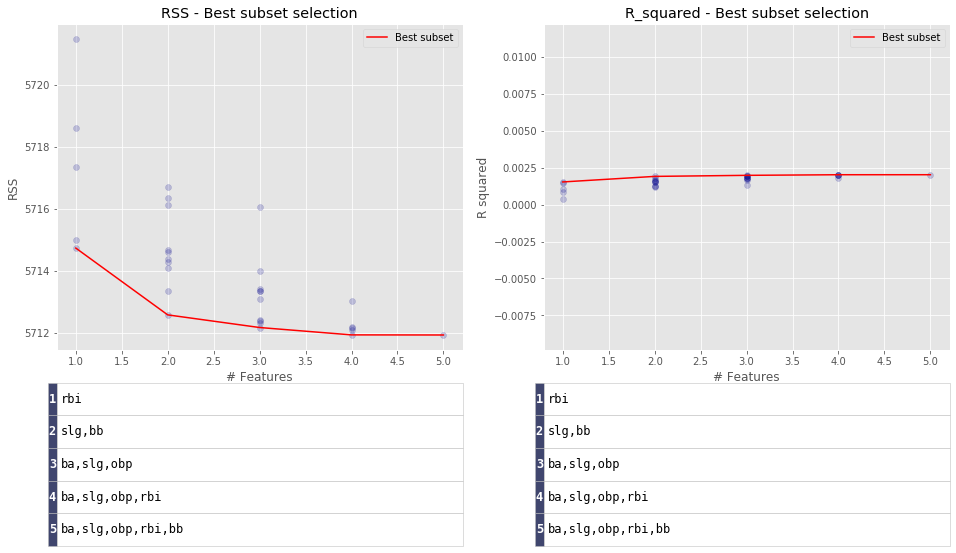

In [26]:
batting_subset = best_subset_selection(dataset, stat_groups['batting'])
plot_best_subset_selection(batting_subset)

100%|██████████| 5/5 [00:00<00:00, 11.57it/s]


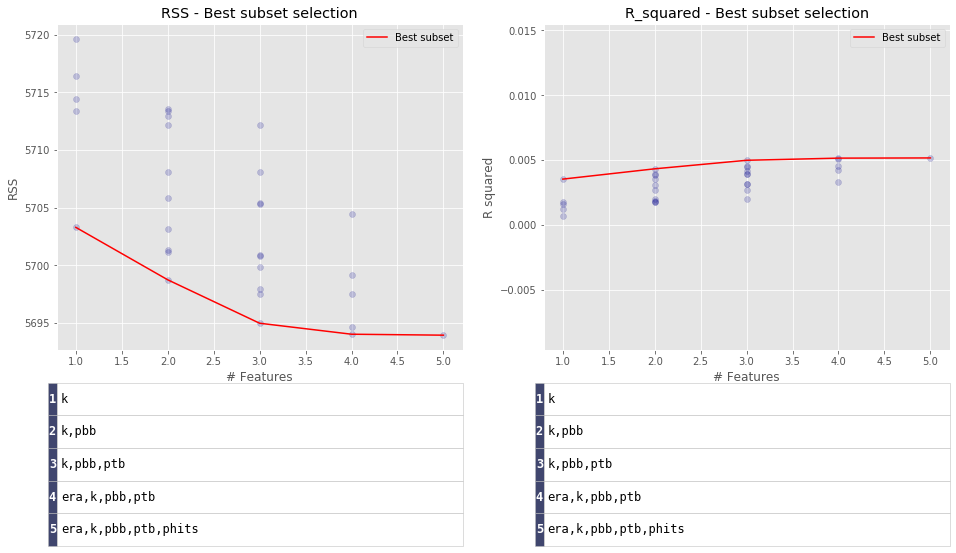

In [25]:
pitching_subset = best_subset_selection(dataset, stat_groups['pitching'])
plot_best_subset_selection(pitching_subset)


100%|██████████| 18/18 [51:42<00:00, 172.37s/it]
/Users/luciancooper/.pyenv/versions/3.7.4/envs/dev/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


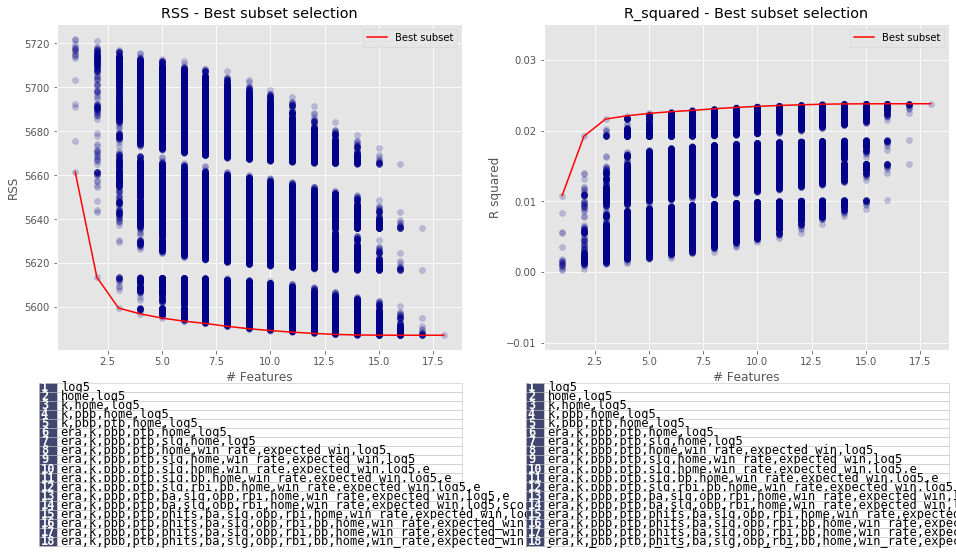

In [38]:
all_subset = best_subset_selection(dataset, stat_groups['pitching']+stat_groups['batting']+stat_groups['team'])
plot_best_subset_selection(all_subset)

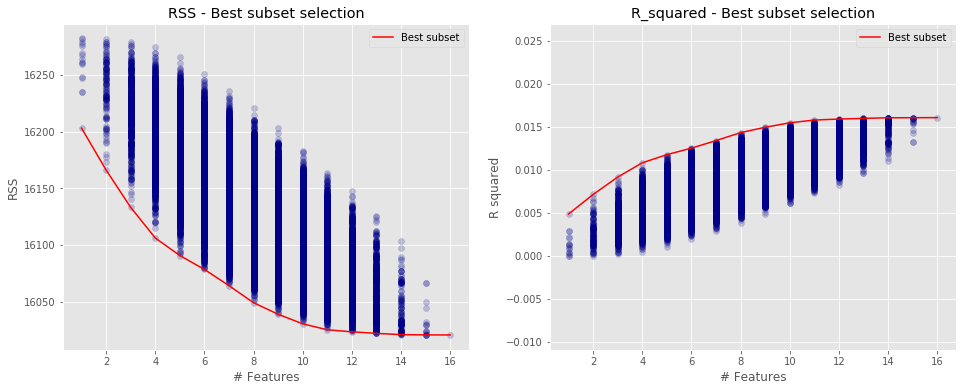

In [21]:
plot_best_subset_selection(all_subset)

# Forward Stepwise Selection
----

Do forward stepwise selection & Compute the following 4 values:

 - Mallow's $C_p$
     - $C_p=\frac{1}{m}(RSS+2d\hat{\sigma}^2)$
 - Akaike's Information Criteria ($AIC$)
     - $AIC=\frac{1}{m\hat{\sigma}^2}(RSS+2d\hat{\sigma}^2)$
 - Bayesian Information Criteria ($BIC$)
     - $BIC=\frac{1}{m\hat{\sigma}^2}(RSS+\log(m)d\hat{\sigma}^2)$
 - Adjusted  $R^2$:
     - $R^{2}_{a} = 1 - \frac{RSS / (m - k - 1)}{TSS / (m-1)}=1 - (1 - R^2)\frac{m-1}{m-k-1}$

In [31]:
def forward_stepwise_selection(data, x, y=dependent_col):
    #Initialization variables
    Y = data[y]
    X = data[x]
    m, k = X.shape

    remaining_features = list(X.columns.values)
    features = []
    RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
    features_list = dict()

    for i in range(1,k+1):
        best_RSS = np.inf
        
        for combo in itertools.combinations(remaining_features,1):

                RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

                if RSS[0] < best_RSS:
                    best_RSS = RSS[0]
                    best_R_squared = RSS[1] 
                    best_feature = combo[0]

        #Updating variables for next loop
        features.append(best_feature)
        remaining_features.remove(best_feature)
        
        #Saving values for plotting
        RSS_list.append(best_RSS)
        R_squared_list.append(best_R_squared)
        features_list[i] = features.copy()
    # combine stepwise results
    df = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
    df['n'] = df.index
    # computing the C_p, AIC, BIC, & R-square adjusted
    hat_sigma_squared = (1/(m - k -1)) * min(df['RSS'])
    # C_p
    df['C_p'] = (1 / m) * (df['RSS'] + 2 * df['n'] * hat_sigma_squared)
    # AIC
    df['AIC'] = (1 / (m * hat_sigma_squared)) * (df['RSS'] + 2 * df['n'] * hat_sigma_squared)
    # BIC
    df['BIC'] = (1 / (m * hat_sigma_squared)) * (df['RSS'] +  np.log(m) * df['n'] * hat_sigma_squared)
    # Adjusted R^2
    df['R_squared_adj'] = 1 - ( (1 - df['R_squared']) * (m - 1)/(m - df['n'] -1))
    return df

def plot_forward_stepwise_selection(df):
    variables = ['C_p', 'AIC','BIC','R_squared_adj']
    fig = plt.figure(figsize = (18,6))

    for i,v in enumerate(variables):
        ax = fig.add_subplot(1, 4, i+1)
        ax.plot(df['n'],df[v], color = 'lightblue')
        ax.scatter(df['n'],df[v], color = 'darkblue')
        if v == 'R_squared_adj':
            ax.plot(df[v].idxmax(),df[v].max(), marker = 'x', markersize = 20)
        else:
            ax.plot(df[v].idxmin(),df[v].min(), marker = 'x', markersize = 20)
        ax.set_xlabel('Number of predictors')
        ax.set_ylabel(v)

    fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
    plt.show()

def display_forward_stepwise_selection(df):
    print(*('({}) {}'.format(i, ', '.join(feat)) for i, feat in df['features'].iteritems()), sep='\n')
    plot_forward_stepwise_selection(df)

(1) log5
(2) log5, home
(3) log5, home, e
(4) log5, home, e, expected_win
(5) log5, home, e, expected_win, win_rate
(6) log5, home, e, expected_win, win_rate, scored_vs_rate
(7) log5, home, e, expected_win, win_rate, scored_vs_rate, win_vs_rate
(8) log5, home, e, expected_win, win_rate, scored_vs_rate, win_vs_rate, lob_rate


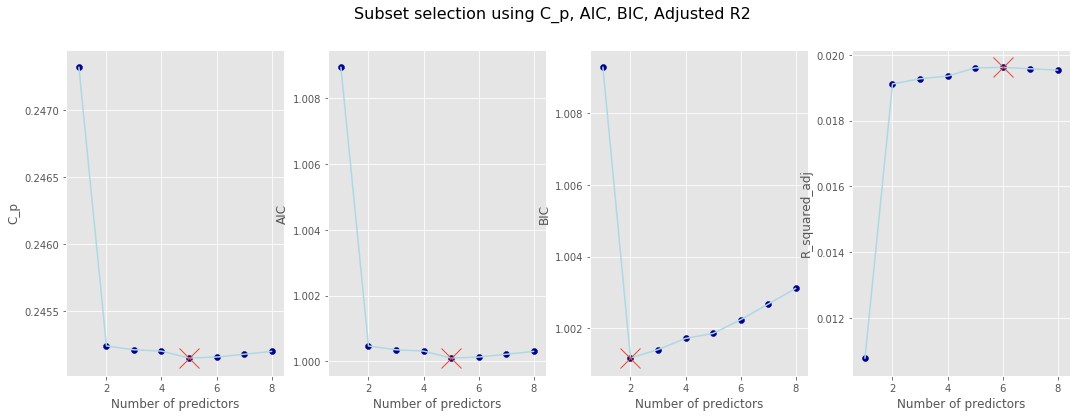

In [32]:
team_forward = forward_stepwise_selection(dataset, stat_groups['team'])
display_forward_stepwise_selection(team_forward)

(1) rbi
(2) rbi, bb
(3) rbi, bb, slg
(4) rbi, bb, slg, ba
(5) rbi, bb, slg, ba, obp


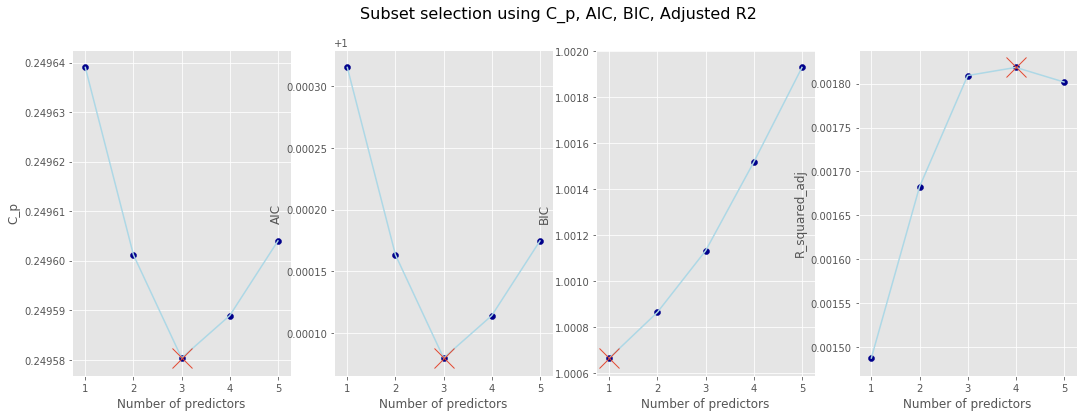

In [33]:
batting_forward = forward_stepwise_selection(dataset, stat_groups['batting'])
display_forward_stepwise_selection(batting_forward)

(1) k
(2) k, pbb
(3) k, pbb, ptb
(4) k, pbb, ptb, era
(5) k, pbb, ptb, era, phits


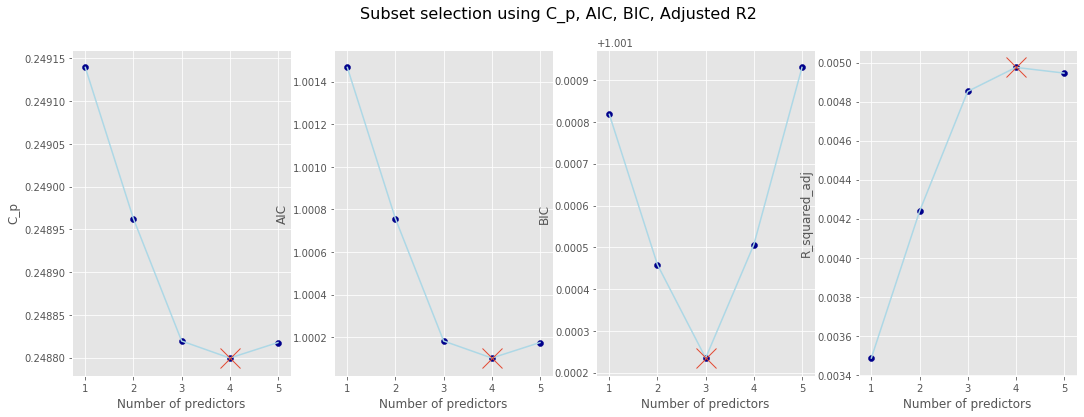

In [34]:
pitching_forward = forward_stepwise_selection(dataset, stat_groups['pitching'])
display_forward_stepwise_selection(pitching_forward)

(1) log5
(2) log5, home
(3) log5, home, k
(4) log5, home, k, pbb
(5) log5, home, k, pbb, ptb
(6) log5, home, k, pbb, ptb, era
(7) log5, home, k, pbb, ptb, era, slg
(8) log5, home, k, pbb, ptb, era, slg, win_rate
(9) log5, home, k, pbb, ptb, era, slg, win_rate, expected_win
(10) log5, home, k, pbb, ptb, era, slg, win_rate, expected_win, e
(11) log5, home, k, pbb, ptb, era, slg, win_rate, expected_win, e, bb
(12) log5, home, k, pbb, ptb, era, slg, win_rate, expected_win, e, bb, rbi
(13) log5, home, k, pbb, ptb, era, slg, win_rate, expected_win, e, bb, rbi, ba
(14) log5, home, k, pbb, ptb, era, slg, win_rate, expected_win, e, bb, rbi, ba, scored_vs_rate
(15) log5, home, k, pbb, ptb, era, slg, win_rate, expected_win, e, bb, rbi, ba, scored_vs_rate, obp
(16) log5, home, k, pbb, ptb, era, slg, win_rate, expected_win, e, bb, rbi, ba, scored_vs_rate, obp, phits
(17) log5, home, k, pbb, ptb, era, slg, win_rate, expected_win, e, bb, rbi, ba, scored_vs_rate, obp, phits, win_vs_rate
(18) log5, hom

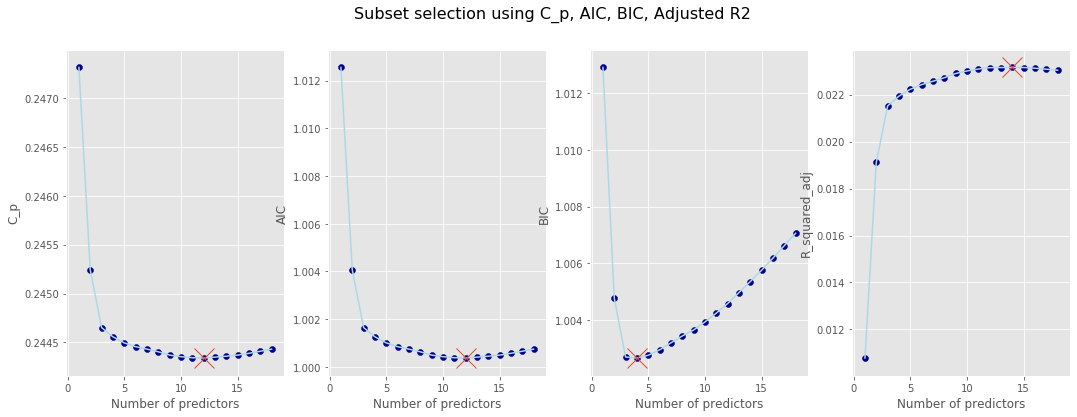

In [37]:
all_forward = forward_stepwise_selection(dataset,stat_groups['pitching']+stat_groups['batting']+stat_groups['team'])
display_forward_stepwise_selection(all_forward)